In [1]:
import os
import sys
import numpy as np
import healpy as hp
import histlite as hl
import csky as cy
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm
import matplotlib.colors as colors

import seaborn as sns
# sns.set_theme(style="whitegrid")

%matplotlib inline
# %matplotlib notebook

from glob import glob
timer = cy.timing.Timer()
time = timer.time

sys.path.append('../../')
from greco_grb.scripts import SETTING
paths = SETTING.PATH()
print(paths)
USER = paths.USER
ICDATA_DIR = paths.ICDATA_DIR
DATA_DIR = paths.DATA_DIR
ANA_DIR = paths.ANA_DIR

from greco_grb.scripts.utils import *


#### Working at GT ####

LOCATION: 	 GT
USER: 	 cchen641
ICDATA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/analyses/online_GRECO/candidate-002-p10
DATA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data
ANA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data/csky_output



In [2]:
import argparse
######################### CONFIGURE ARGUEMENTS #############################
# p = argparse.ArgumentParser(description="Save multiple background p-values(effective corrected) for null hypothesis binomial test",
#                             formatter_class=argparse.RawTextHelpFormatter)
# p.add_argument("--num_run", default=1, type=int, help="number of runs")
# p.add_argument("--batch_idx", default=0, type=int, help="starting index of runs")
# args = p.parse_args()
###########################################################################

### testing on jupyter ###
class args:
    num_run = 3
    batch_idx = 29
##########################

In [3]:
print("\n===== Setting up csky =====\n")
data_dir = ICDATA_DIR
data_filenames = sorted(glob(data_dir + '/IC86_20*.data.npy'))
sig_filenames = sorted(glob(data_dir + '/IC86_2012.nu*_merged.npy'))
grl_filenames = sorted(glob(data_dir + '/GRL/IC86_20*.data.npy'))

################ energy lower bound #############
min_log_e = np.log10(10)
#################################################
bins_sindec = np.linspace(-1, 1, 25+1)  
bins_logenergy = np.linspace(min_log_e, 4, 25+1)

data = [np.load(data_filename) for data_filename in data_filenames]
data = np.hstack(data)
sig = [np.load(sig_filename) for sig_filename in sig_filenames]
sig = np.hstack(sig)
grl = [np.load(grl_filename) for grl_filename in grl_filenames]
grl = np.hstack(grl)
if min_log_e is not None:
    data_mask = data['logE'] > min_log_e
    data = data[data_mask]
    sig_mask = sig['logE'] > min_log_e
    sig = sig[sig_mask]
    
dataset_spec = cy.selections.CustomDataSpecs.CustomDataSpec(data, sig, np.sum(grl['livetime']),
                                                     sindec_bins=bins_sindec,
                                                     logenergy_bins=bins_logenergy,
                                                     grl=grl, key='greco_v2.10', cascades=True)

ANA_DIR = cy.utils.ensure_dir(ANA_DIR)
# on OSG
# ana_dir = "./"
ana = cy.get_analysis(cy.selections.repo
                      , dataset_spec
                      , dir=ANA_DIR
                      , load_sig=True)  # to save memory: use False





===== Setting up csky =====

Setting up Analysis for:
greco_v2.10
Setting up greco_v2.10...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.


# 1. Non-injection Binomial Test

In [4]:
from scipy import stats
def binomial_test(p_values, epsilon=None):
    """
    Perform IceCube binomial test
    
    Parameters
    ----------
        p_values: array_like
            an array of p-values
        
    Returns
    -------
        best_k: int
            number of p-values that minimizes the binomial probability
            Note this is 1-index'ed
        
        best_binomial_p: float
            the optimized binomial probability
            
        threshold_p_value: float
            the best_k-th p_value (a.k.a. p_k)
            this GRB and all GRBs having p_values smaller than this threshold_p_value are important
            
        indices: array_like
            GRB indices after sorting (assume the input p_values' indices are from 1 - 2268)
            
        
        binomial_ps: array_like
            binomial probabilities for different k=1,2,...,N
    """
    p_values = np.array(p_values)
    N = p_values.size
    ks = np.argsort(p_values)
    p_values = np.sort(p_values)
    binomial_ps = stats.binom.sf(np.r_[0:N], N, p_values)
    best_k = np.argmin(binomial_ps) + 1
    best_binomial_p = binomial_ps[best_k - 1]
    if (epsilon is not None) and (1.0 - best_binomial_p < epsilon):
        return N, 1, p_values[-1], ks, binomial_ps
    threshold_p_value = p_values[best_k - 1]
    return best_k, best_binomial_p, threshold_p_value, ks, binomial_ps

In [5]:
# test
binomial_test([1e-6, 1e-4, 1.0, 0.8, 1.0]) # the first 2 are significant

(2,
 9.998000149996001e-08,
 0.0001,
 array([0, 1, 3, 2, 4]),
 array([4.99999000e-06, 9.99800015e-08, 9.42080000e-01, 1.00000000e+00,
        1.00000000e+00]))

In [6]:
def get_post_p_for_grb(grb_name, pre_p):
    """
    effective trial correction due to multiple time windows
    
    Parameters
    ----------
        grb_name: str
            name of the grb
        pre_p: float or array_like
            one or multiple pre_trial p value(s)
        
    Returns
    -------
        post_p: float or array_like
            one or multiple post_trial p value(s)
    """
    pre_p = np.float32(pre_p)
    pre_post = np.load(ANA_DIR + f"/effective_trial/pre_post/{grb_name}_effective_trial.npy")
    idx = np.searchsorted(pre_post['pre_trial_p'], pre_p, side='right') - 1
    idx = np.maximum(idx, 0)
    idx = np.minimum(idx, pre_post['post_trial_p'].shape[0] - 1)
    return pre_post['post_trial_p'][idx]
    
    
def get_post_p(pre_post, pre_p):
    """
    effective trial correction due to multiple time windows
    
    Parameters
    ----------
        pre_post: ndarray
            Npy from (ANA_DIR + f"/effective_trial/pre_post/{grb_name}_effective_trial.npy")
            dtype=[('pre_trial_p', '<f4'), ('post_trial_p', '<f4')])
        pre_p: float or array_like
            one or multiple pre_trial p value(s)
        
    Returns
    -------
        post_p: float or array_like
            one or multiple post_trial p value(s)
    """
    pre_p = np.float32(pre_p)
    idx = np.searchsorted(pre_post['pre_trial_p'], pre_p, side='right') - 1
    idx = np.maximum(idx, 0)
    idx = np.minimum(idx, pre_post['post_trial_p'].shape[0] - 1)
    return pre_post['post_trial_p'][idx]

In [7]:
# test
get_post_p_for_grb(grb_name="GRB180423A", pre_p=[1e-7, 1e-6, 0.1, 0.197843, 0.197844, 0.99999, 1.0, 1.2])

array([6.00000e-06, 6.00000e-06, 2.64868e-01, 3.67735e-01, 3.67736e-01,
       3.67736e-01, 1.00000e+00, 1.00000e+00], dtype=float32)

## 1.1 single null binomial examples

In [8]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

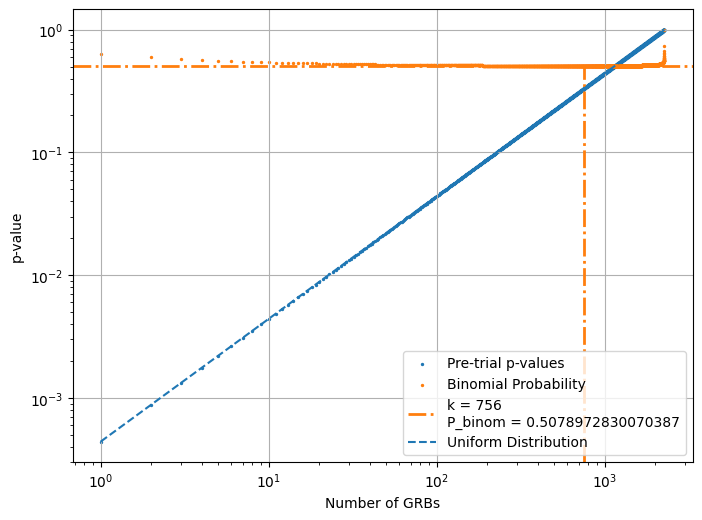

In [9]:
# Uniformly distributed Binomial Test
## example null hypothesis Binomial Test
# grb_tw_pre_post_p = pd.DataFrame(get_all_GRB_best_p_values(0)) # 0 is a random number bewteen 0-1,000,000
x = np.r_[1:2268+1]
binomial_result = binomial_test(x/2268.)

fig, ax = plt.subplots(figsize=(8,6), dpi=100)
# 2268 GRBs
x = np.r_[1:2268+1]
# p_values
ax.scatter(x, np.sort(x/2268.), label="Pre-trial p-values", s=2)
# Binomial Probability
ax.scatter(x, binomial_result[4], label="Binomial Probability", s=2)
# best Binomial
ax.vlines(binomial_result[0], 0, binomial_result[1], 
           linestyle='-.', color=sns.color_palette()[1], linewidth=2)
ax.axhline(binomial_result[1], 0, 2268, 
           linestyle='-.', color=sns.color_palette()[1], linewidth=2,
           label=f"k = {binomial_result[0]}\nP_binom = {binomial_result[1]}")

# uniform line
ax.plot(x, x/2268., "--", label="Uniform Distribution")

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Number of GRBs")
ax.set_ylabel("p-value")
# ax.set_title(f"{ag.grb_name}")
ax.grid(True)
ax.legend()

In [10]:
import multiprocessing as mp

def get_grb_pre_post_p(grb_name, trial_no):
    """
    A helper function for function:get_all_GRB_best_p_values
    Returns
    -------
        grb_name, best tw index, pre-trial p, post-trial p (after TW trial correction)
    """
    pre_trial_tw_p = np.load(ANA_DIR + f"/effective_trial/min_tw_p/{grb_name}_min_tw_p.npy")[trial_no]
    post_trial_p = get_post_p_for_grb(grb_name, pre_trial_tw_p[1])
    return (grb_name, pre_trial_tw_p[0], pre_trial_tw_p[1], post_trial_p)

def get_all_GRB_best_p_values(trial_no):
    """
    Get 2268 p-values at the trial_no-th trial. 
    An array of (grb_name, tw_index, pre_p, post_p) will be returned
    The post_p are p-values corrected with `effective_trial/pre_post`
    
    Parameters
    ----------
        trial_no: int
            Some value between 0 and N (N is 1,000,000)
        
    Returns
    -------
        grb_tw_pre_post_p: array_like
            2268 (grb_name, tw_index, pre_p, post_p)
    """
        
    df = pd.read_pickle(DATA_DIR+"/grbwebgbm/grbweb_gbm_noHealpix_2268.pkl")
    grb_tw_pre_post_p = []
    with mp.Pool() as pool:
        grb_tw_pre_post_p = np.array(
            pool.starmap(
                get_grb_pre_post_p, 
                zip(list(df.grb_name.values),[trial_no]*len(df.grb_name))
            )
        )
    dt = np.dtype([('grb_name', 'U10'), 
                   ('tw_idx', np.intc), 
                   ('pre_trial_p', np.float32), 
                   ('post_trial_p', np.float32)])
    grb_tw_pre_post_p = np.array(
        list(map(tuple, grb_tw_pre_post_p)), 
        dtype=dt
    )
    return grb_tw_pre_post_p

In [11]:
# test
get_grb_pre_post_p(grb_name="GRB180423A", trial_no=1)

('GRB180423A', 5, 0.074062, 0.220239)

In [12]:
"""
Plotting un-permuted Binomial examples
"""

def plot_null_binom_example(trial_no):
    ## example null hypothesis Binomial Test
    grb_tw_pre_post_p = pd.DataFrame(get_all_GRB_best_p_values(trial_no)) # trial_no is a random number bewteen 0-1,000,000
    binomial_result = binomial_test(grb_tw_pre_post_p['post_trial_p'])
    fig, ax = plt.subplots(figsize=(8,6), dpi=100)
    # 2268 GRBs
    x = np.r_[1:2268+1]
    # p_values
    ax.scatter(x, np.sort(grb_tw_pre_post_p['post_trial_p']), label="Pre-trial p-values", s=2)
    # Binomial Probability
    ax.scatter(x, binomial_result[4], label="Binomial Probability", s=2)
    # best Binomial
    ax.vlines(binomial_result[0], 0, binomial_result[1], 
               linestyle='-.', color=sns.color_palette()[1], linewidth=2)
    ax.axhline(binomial_result[1], 0, 2268, 
               linestyle='-.', color=sns.color_palette()[1], linewidth=2,
               label=f"k = {binomial_result[0]}\nP_binom = {binomial_result[1]}")
    # uniform line
    ax.plot(x, x/2268., "--")

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("Number of GRBs")
    ax.set_ylabel("p-value")
    # ax.set_title(f"{ag.grb_name}")
    ax.grid(True)
    ax.legend()
    return ax, binomial_result

(<AxesSubplot:xlabel='Number of GRBs', ylabel='p-value'>,
 (1827,
  1.4367222464612875e-284,
  0.436596,
  array([ 613,  928,  765, ...,  868,  515, 1087]),
  array([0.77830488, 0.45026525, 0.30439484, ..., 1.        , 1.        ,
         1.        ])))

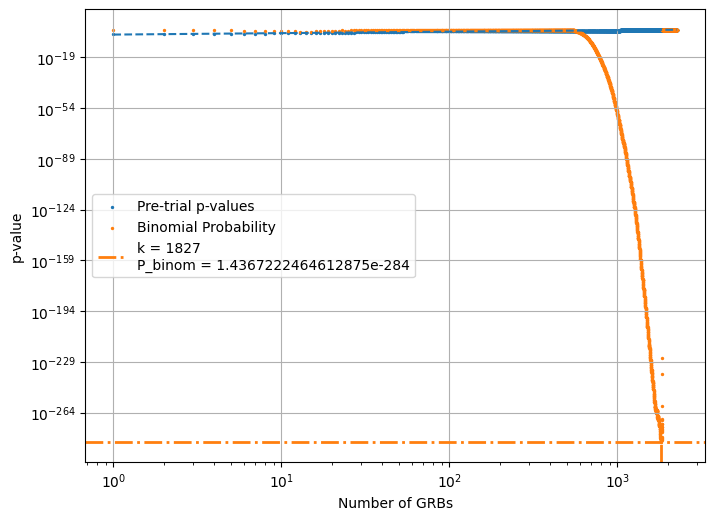

In [13]:
plot_null_binom_example(1)

In [14]:
def plot_pretrial_example(trial_no):
    ## example null hypothesis Binomial Test
    grb_tw_pre_post_p = pd.DataFrame(get_all_GRB_best_p_values(trial_no)) # trial_no is a random number bewteen 0-1,000,000
    binomial_result = binomial_test(grb_tw_pre_post_p['post_trial_p'])
    fig, ax = plt.subplots(figsize=(8,6), dpi=100)
    # 2268 GRBs
    x = np.r_[1:2268+1]
    # p_values
    ax.scatter(x, np.sort(grb_tw_pre_post_p['post_trial_p']), label="Pre-trial p-values", s=2)
    # uniform line
    ax.plot(x, x/2268., "--")

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("Number of GRBs")
    ax.set_ylabel("p-value")
    # ax.set_title(f"{ag.grb_name}")
    ax.grid(True)
    ax.legend()
    return ax, binomial_result

(<AxesSubplot:xlabel='Number of GRBs', ylabel='p-value'>,
 (1827,
  1.4367222464612875e-284,
  0.436596,
  array([ 613,  928,  765, ...,  868,  515, 1087]),
  array([0.77830488, 0.45026525, 0.30439484, ..., 1.        , 1.        ,
         1.        ])))

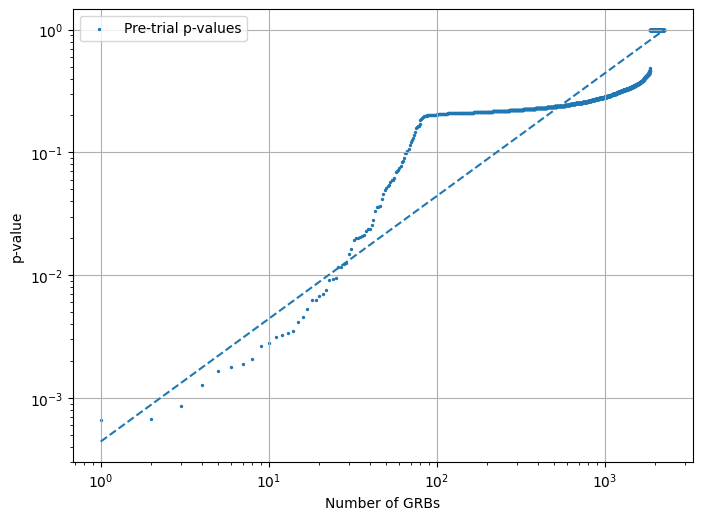

In [15]:
plot_pretrial_example(1)

In [16]:
# ## Two experiments illustrating that
# ## The binomial test is sensitive to deviation at high-rank GRBs
# ## but robust to deviation at low-rank GRBs

# x = np.r_[0:2268]
# a = [0.9, 1.0, 1.1]
# fig, ax = plt.subplots(figsize=(8,6), dpi=80)
# for aa, la in zip(a[::-1], ['low','normal','high'][::-1]):
#     # Test 1, ratio * rank / N
# #     p = np.minimum(1.0, np.maximum(1/22680, aa*x/2268))
# #     y = stats.binom.sf(x, 2268, p)
#     ## 1.1 pre-trial p-values
# #     ax.scatter(x, p, label=f"{la} pre-trial p-values", s=1)
#      ## 1.2 Binomial p-values
# #     ax.scatter(x, y, label=f"{la} Binomial p-values", s=1)
    
#     # Test 2, rank / N +/- offset
#     p = np.minimum(1.0, np.maximum(1/22680, x/2268 - 0.05*(1-aa)))
#     y = stats.binom.sf(x, 2268, p)
#     ## 2.1 pre-trial p-values
# #     ax.scatter(x, p, label=f"{la} pre-trial p-values", s=1)
#     ## 2.2 Binomial p-values
#     ax.scatter(x, y, label=f"{la} Binomial p-values", s=1)
    
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlabel("Number of GRBs")
# ax.set_ylabel("p-value") 
# ax.grid(True)
# ax.legend()

## 1.2 Multiple null Binomials

In [17]:
def get_multiple_run_post_p(num_run, batch_idx=0, load=False):
    """
    Get num_run * 2268 p-values. 
    The post_p are p-values corrected with `effective_trial/pre_post`
    
    Parameters
    ----------
        num_run: int
            First a few runs starting from batch_idx * num_run (e.g. 1000)
        
        batch_idx: int
            get num_run runs from start_idx (e.g.  [batch_idx*num_run, (batch_idx+1)*num_run))
            if -1 (only when load=True), get all batches with num_run
            
        load: bool
            are we loading or making runs
        
    Returns
    -------
        multiple_run_post_p: array_like
            shape: num_run * 2268
    """
    print(f"Running num_run {num_run}, batch_idx {batch_idx}")
    multiple_run_post_p = []
    # get_all_GRB_best_p_values is using multiprocessing
    # so we cannot use multiprocessing here
    if batch_idx==-1:
        assert load == True
    if load:
        if batch_idx==-1:
            files = glob(ANA_DIR+f"/binomial_test/null_binom/multiple_run_post_p/multiple_run_post_p_numRun{num_run}_batchIdx*.npy")
            files = sorted(files, key=lambda x: int(x[x.find("_batchIdx")+9:x.find(".npy")]))
        else:
            files= glob(ANA_DIR+f"/binomial_test/null_binom/multiple_run_post_p/multiple_run_post_p_numRun{num_run}_batchIdx{batch_idx}.npy")
        return np.vstack([np.load(x) for x in files])
    
    # load all GRB names
    df = pd.read_pickle(DATA_DIR+"/grbwebgbm/grbweb_gbm_noHealpix_2268.pkl")
    for grb_name in df.grb_name.values:
        # load pre_trial_tw_p_grb for this grb
        pre_trial_tw_p_grb = np.load(ANA_DIR + f"/effective_trial/min_tw_p/{grb_name}_min_tw_p.npy")
        # load for pre_post this grb
        pre_post = np.load(ANA_DIR + f"/effective_trial/pre_post/{grb_name}_effective_trial.npy")
        
        ## multiple_run_post_p_grb for this grb
        multiple_run_post_p_grb = []
        for i in range(batch_idx*num_run, (batch_idx+1)*num_run):
            pre_trial_tw_p = pre_trial_tw_p_grb[i]
            single_run_post_p_grb = get_post_p(pre_post, pre_trial_tw_p[1])
            multiple_run_post_p_grb.append(single_run_post_p_grb)
        multiple_run_post_p.append(multiple_run_post_p_grb)
        
    # make the return to shape N*2268
    multiple_run_post_p = np.array(multiple_run_post_p).transpose()
    return multiple_run_post_p

In [18]:
# # test
# with time("get multiple run post p"):
#     get_multiple_run_post_p(1, batch_idx=29, load=False)

In [19]:
def save_multiple_run_post_p(num_run, batch_idx=0):
    multiple_run_post_p = get_multiple_run_post_p(num_run, batch_idx=batch_idx, load=False)
    np.save(ANA_DIR+f"/binomial_test/null_binom/multiple_run_post_p_numRun{num_run}_batchIdx{batch_idx}.npy", 
            multiple_run_post_p)

In [20]:
# # test
# with time("save multiple run post p"):
#     save_multiple_run_post_p(10, batch_idx=21)

In [21]:
# # test
with time("load all run post p"):
    print(get_multiple_run_post_p(2500, batch_idx=0, load=True).shape)

Running num_run 2500, batch_idx 0
(2500, 2268)

0:00:00.070972 elapsed.


In [22]:
# ## example null hypothesis Binomial Test - Multiple Runs - 5000 Runs ### NOT A GOOD PLOT
# runs = 5000
# multiple_run_post_p = get_multiple_run_post_p(runs, load=True)
# multiple_run_post_p = np.sort(multiple_run_post_p, axis=1)

# p_values = np.median(multiple_run_post_p, axis=0)
# p_value_16 = np.quantile(multiple_run_post_p, 0.16, axis=0)
# p_value_84 = np.quantile(multiple_run_post_p, 0.84, axis=0)

# binomial_result = binomial_test(p_values)

# fig, ax = plt.subplots(figsize=(8,6), dpi=100)
# # 2268 GRBs
# x = np.r_[1:2268+1]
# # p_values
# ax.scatter(x, p_values, label="Median Pre-trial p-values", s=2)
# # p_values error
# ax.errorbar(x, p_values, yerr=[p_values-p_value_16, p_value_84-p_values], fmt='none',alpha=0.1)
# # Binomial Probability
# ax.scatter(x, binomial_result[4], label="Binomial Probability", s=2)
# # best Binomial
# ax.vlines(binomial_result[0], 0, binomial_result[1], 
#            linestyle='-.', color=sns.color_palette()[1], linewidth=2)
# ax.axhline(binomial_result[1], 0, 2268, 
#            linestyle='-.', color=sns.color_palette()[1], linewidth=2,
#            label=f"k = {binomial_result[0]}\nP_binom = {binomial_result[1]}")
# # uniform line
# ax.plot(x, x/2268., "--")

# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlabel("Number of GRBs")
# ax.set_ylabel("p-value")
# ax.set_title(f"Binomial p-values of {runs} Trials")
# ax.grid(True)
# ax.legend()

## 1.3 CDF of pre-trial p-values for all GRBs (not pre-trial binomial)

In [23]:
## #example null hypothesis Binomial Test - Multiple Runs
## 10,000 runs
multiple_run_post_p = np.vstack([get_multiple_run_post_p(2500, batch_idx=i, load=True) for i in np.r_[0:4]])
## all 1,000,000 runs
# multiple_run_post_p = get_multiple_run_post_p(2500, batch_idx=-1, load=True)

Running num_run 2500, batch_idx 0
Running num_run 2500, batch_idx 1
Running num_run 2500, batch_idx 2
Running num_run 2500, batch_idx 3


In [24]:
multiple_run_post_p.shape

(10000, 2268)

In [25]:
all_pre_p = np.ravel(multiple_run_post_p)

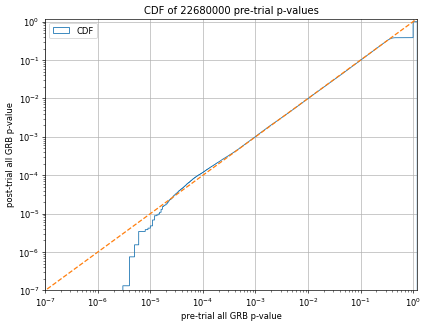

In [26]:
fig, ax = plt.subplots(figsize=(8,6), dpi=60)
n,bins,patches=ax.hist(all_pre_p, 
        bins=np.r_[np.unique(all_pre_p),1.2], 
        density=True, 
        cumulative=True, 
        label=f'CDF',
        histtype='step')
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, "--")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.1e-6, 1.2)
ax.set_ylim(0.1e-6, 1.2)
ax.set_xlabel("pre-trial all GRB p-value")
ax.set_ylabel("post-trial all GRB p-value")
ax.set_title(f"CDF of {all_pre_p.size} pre-trial p-values")
ax.grid(True)
ax.legend()

## 1.4 Permuted pre-trial p-values and resulting Binomial p-values

### 1.4.1 Results of 10,000 runs

In [27]:
multiple_null_binomial_results = np.array([binomial_test(single_run_post_p, epsilon=None) for single_run_post_p in multiple_run_post_p])
multiple_null_binomial_results[:2]


/storage/home/hhive1/cchen641/.conda/envs/icecube_py3/lib/python3.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


array([[2, 0.9999999999999999, 0.315185,
        array([ 172,  381,  769, ...,  792,  808, 1133]),
        array([1., 1., 1., ..., 1., 1., 1.])],
       [1827, 1.4367222464612875e-284, 0.436596,
        array([ 613,  928,  765, ...,  868,  515, 1087]),
        array([0.77830488, 0.45026525, 0.30439484, ..., 1.        , 1.        ,
               1.        ])                                                    ]],
      dtype=object)

In [28]:
# for i, re in enumerate(multiple_null_binomial_results):
#     if re[0] == 1: # best k is 1
#         print(i)
#         print(re)
#         plot_null_binom_example(i)
#         break
 

In [29]:
# for i, re in enumerate(multiple_null_binomial_results):
#     if re[1] == 0: # best binomial p-value is 0
#         print(i)
#         print(re)
#         plot_null_binom_example(i)  
#         break  

In [30]:
# for i, re in enumerate(multiple_null_binomial_results):
#     if re[2] < 1e-3: # p_k < 1e-3
#         print(i)
#         print(re)
#         plot_null_binom_example(i)  
#         break  

In [31]:
"""
Note: grb_name indices will NOT get permuted
"""

seed = 0

rng = np.random.default_rng(seed)
with time(f"Permute post p's"):
    multiple_run_post_p_permuted = rng.permuted(multiple_run_post_p, axis=0)

with time(f"Get binomial test for {multiple_run_post_p.shape[0]} runs"):
    multiple_permuted_null_binomial_results = np.array([binomial_test(single_run_post_p, epsilon=None) for single_run_post_p in multiple_run_post_p_permuted])
multiple_permuted_null_binomial_results[:2]



0:00:00.602848 elapsed.

0:00:11.749169 elapsed.


/storage/home/hhive1/cchen641/.conda/envs/icecube_py3/lib/python3.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


array([[113, 0.21503805756363495, 0.046153,
        array([ 312,  926,  431, ...,  929,  944, 2267]),
        array([0.75390983, 0.8068179 , 0.96555825, ..., 1.        , 1.        ,
               1.        ])                                                    ],
       [5, 0.055305354851481046, 0.000895,
        array([1906,  535,   31, ..., 1082, 1096, 1133]),
        array([0.19930476, 0.23347063, 0.32035465, ..., 1.        , 1.        ,
               1.        ])                                                    ]],
      dtype=object)

In [32]:
all_premuted_binomial_k = np.ravel([x[0] for x in multiple_permuted_null_binomial_results])
all_premuted_best_binomial_p = np.ravel([x[1] for x in multiple_permuted_null_binomial_results])


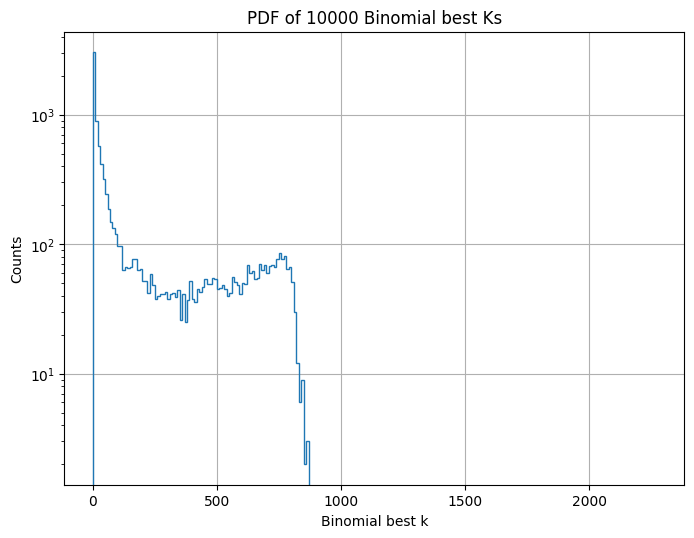

In [33]:
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
n,bins,patches=ax.hist(all_premuted_binomial_k, 
                        bins=np.r_[0:2268+10:10], 
                        density=False, 
                        cumulative=False, 
                        histtype='step')

# ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_xlim(0.8e-6, 1.2)
# ax.set_ylim(0.8e-6, 1.2)
ax.set_xlabel("Binomial best k")
ax.set_ylabel("Counts")
ax.set_title(f"PDF of {all_premuted_binomial_k.size} Binomial best Ks")
ax.grid(True)
# ax.legend()

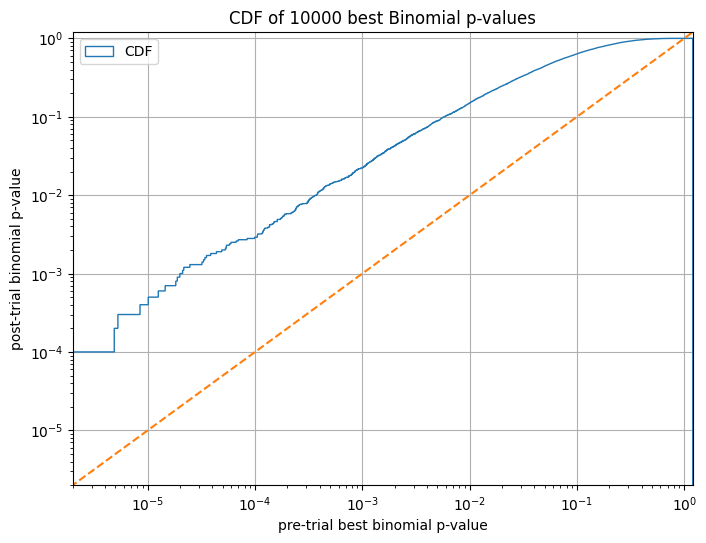

In [34]:
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
n,bins,patches=ax.hist(all_premuted_best_binomial_p, 
                       bins=np.r_[np.unique(all_premuted_best_binomial_p), 1.2],
        density=True, 
        cumulative=True, 
        label=f'CDF',
        histtype='step')
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, "--")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.2e-5, 1.2)
ax.set_ylim(0.2e-5, 1.2)
ax.set_xlabel("pre-trial best binomial p-value")
ax.set_ylabel("post-trial binomial p-value")
ax.set_title(f"CDF of {all_premuted_best_binomial_p.size} best Binomial p-values")
ax.grid(True)
ax.legend()

In [35]:
def plot_binom_example_from_p_values(p_values, mark_indices=[]):
    """
    p_values here are assumed corrected already
    
    Parameters
    ----------
        p_values: array_like
            shape: 2268
            
        mark_indices: array_like
            0-indexed: 0,1,2,...,2267
            if provided, draw those p-values differently
        
    Returns
    -------
        ax: matplotlib axes
            
        binomial_result: dict
    
    """
    ## example null hypothesis Binomial Test
    binomial_result = binomial_test(p_values)

    fig, ax = plt.subplots(figsize=(8,6), dpi=100)
    # 2268 GRBs
    x = np.r_[1:2268+1]
    # p_values
    sorted_p_values = np.sort(p_values)
    ax.scatter(x, sorted_p_values, label="Pre-trial p-values", s=2)
    if len(mark_indices) > 0:
        mark_indices = np.array(mark_indices)
        sorted_indices = np.argsort(p_values)
        mark_ks = np.ravel([np.argwhere(sorted_indices==x) for x in mark_indices]) + 1
        ax.scatter(mark_ks, sorted_p_values[mark_ks-1], color=sns.color_palette()[2], s=20, marker="x", label="Marked p-value(s)")
    # Binomial Probability
    ax.scatter(x, binomial_result[4], label="Binomial p-values", s=2)
    # best Binomial
    ax.vlines(binomial_result[0], 0, binomial_result[1], 
               linestyle='-.', color=sns.color_palette()[1], linewidth=2)
    ax.axhline(binomial_result[1], 0, 2268, 
               linestyle='-.', color=sns.color_palette()[1], linewidth=2,
               label=f"k = {binomial_result[0]}\nP_binom = {binomial_result[1]}")
    # uniform line
    ax.plot(x, x/2268., "--")

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("Number of GRBs")
    ax.set_ylabel("p-value")
    # ax.set_title(f"{ag.grb_name}")
    ax.grid(True)
    ax.legend()
    return ax, binomial_result

7 [3 0.16520694305722178 0.000615
 array([ 652,   19,  787, ...,  915,  912, 2267])
 array([0.49017922, 0.16558861, 0.16520694, ..., 1.        , 1.        ,
        1.        ])                                                    ]


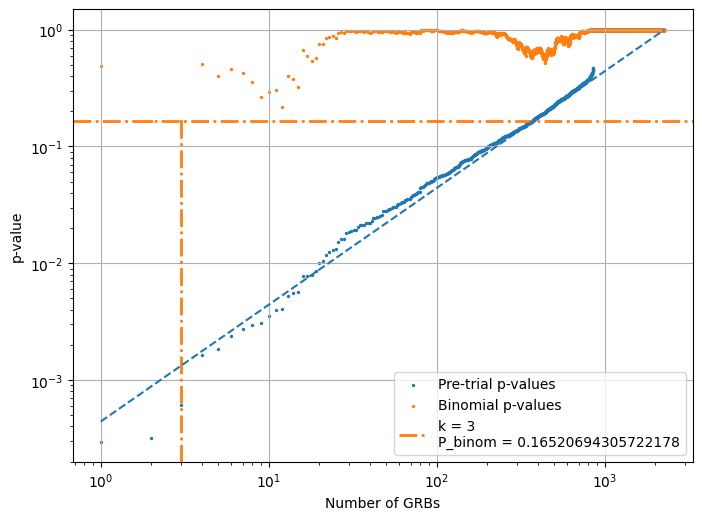

In [36]:
for i in range(multiple_permuted_null_binomial_results.shape[0]):
    if multiple_permuted_null_binomial_results[i][0] == 3:
        print(i, multiple_permuted_null_binomial_results[i])
        plot_binom_example_from_p_values(multiple_run_post_p_permuted[i])
        break

1089 [800 0.01580455449044047 0.331186
 array([2164, 1436,  858, ...,  539, 1562, 2267])
 array([0.72056183, 0.39855046, 0.57044345, ..., 1.        , 1.        ,
        1.        ])                                                    ]


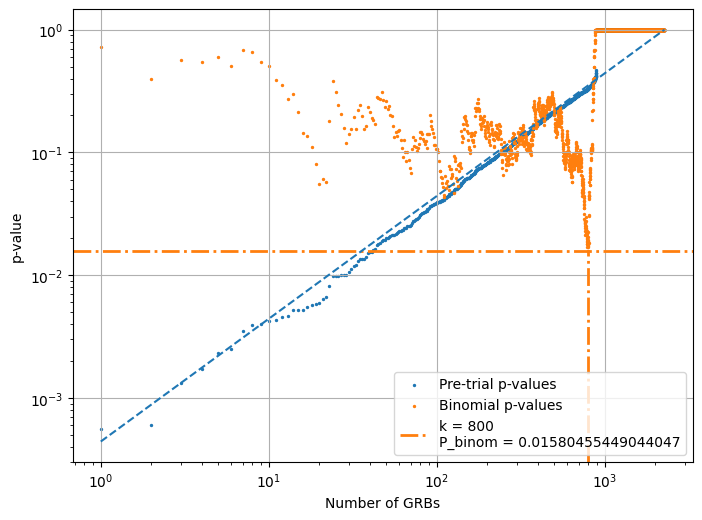

In [37]:
for i in range(multiple_permuted_null_binomial_results.shape[0]):
    if multiple_permuted_null_binomial_results[i][0] == 800:
        print(i, multiple_permuted_null_binomial_results[i])
        plot_binom_example_from_p_values(multiple_run_post_p_permuted[i])
        break

### 1.4.2 Results of 1,000,000 runs and 100,000,000 runs

In [70]:
best_binomial_p_10000 = all_premuted_best_binomial_p

In [69]:
## best_k, best_binomial_p, threshold_p_value
null_binomial_results_numRun1000000_seed0 = np.load(ANA_DIR+f"/binomial_test/null_binom/binomial_results/null_binomial_results_numRun1000000_seed0.npy")
best_binomial_p_1000000 = null_binomial_results_numRun1000000_seed0[:,1]


In [199]:
files = glob(ANA_DIR+f"/binomial_test/null_binom/binomial_results/null_binomial_results_numRun1000000_seed*.npy")
files = sorted(files, key=lambda x: int(x[x.find("_seed")+5:x.find(".npy")]))
best_binomial_p_100000000 = np.concatenate([np.load(file) for file in files])[:,1]

In [200]:
best_binomial_p_100000000.shape

(100000000,)

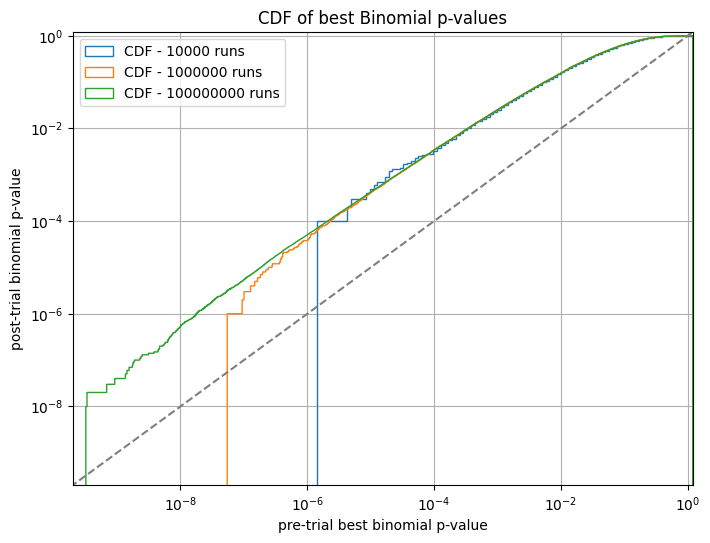

In [294]:
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
n,bins,patches=ax.hist(best_binomial_p_10000, 
                       bins=np.r_[
                           np.logspace(np.log10(best_binomial_p_10000.min()),np.log10(1.0), 100), 
                           1.2
                       ],
        density=True, 
        cumulative=True, 
        label=f'CDF - {best_binomial_p_10000.size} runs',
        histtype='step')

n,bins,patches=ax.hist(best_binomial_p_1000000, 
                       bins=np.r_[
                           np.logspace(np.log10(best_binomial_p_1000000.min()),np.log10(1.0), 1000), 
                           1.2
                       ],
        density=True, 
        cumulative=True, 
        label=f'CDF - {best_binomial_p_1000000.size} runs',
        histtype='step')

n,bins,patches=ax.hist(best_binomial_p_100000000, 
                       bins=np.r_[
                           np.logspace(np.log10(best_binomial_p_100000000.min()),np.log10(1.0), 100000), 
                           1.2
                       ],
        density=True, 
        cumulative=True, 
        label=f'CDF - {best_binomial_p_100000000.size} runs',
        histtype='step')


x = np.linspace(*ax.get_xlim())
ax.plot(x, x, "--", color=sns.color_palette()[7])

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.2e-9, 1.2)
ax.set_ylim(0.2e-9, 1.2)
ax.set_xlabel("pre-trial best binomial p-value")
ax.set_ylabel("post-trial binomial p-value")
ax.set_title(f"CDF of best Binomial p-values")
ax.grid(True)
ax.legend()

# 2. Signal-hypothesis Binomial Test

In [92]:
multiple_run_post_p_permuted.shape

(10000, 2268)

In [93]:
df = pd.read_pickle(DATA_DIR+"/grbwebgbm/grbweb_gbm_noHealpix_2268.pkl")
multiple_run_post_p_permuted[:2], multiple_permuted_null_binomial_results[:2]


(array([[0.062299, 1.      , 0.158255, ..., 0.024996, 1.      , 1.      ],
        [0.097073, 0.193847, 0.101656, ..., 1.      , 1.      , 0.149533]],
       dtype=float32), array([[113, 0.21503805756363495, 0.046153,
         array([ 312,  926,  431, ...,  929,  944, 2267]),
         array([0.75390983, 0.8068179 , 0.96555825, ..., 1.        , 1.        ,
                1.        ])                                                    ],
        [5, 0.055305354851481046, 0.000895,
         array([1906,  535,   31, ..., 1082, 1096, 1133]),
         array([0.19930476, 0.23347063, 0.32035465, ..., 1.        , 1.        ,
                1.        ])                                                    ]],
       dtype=object))

In [146]:
def get_replaced_p_values(p_values, 
                          num_to_replace=1, 
                          grb_name_indices_to_replace=[], 
                          replaced_p=stats.norm.sf(3), 
                          seed=0,
                          return_replaced_indices=False,
                          grb_name_indices=np.r_[0:2268:1]):
    """
    Get 2268 p-values. 
    The post_p are p-values corrected with `effective_trial/pre_post`
    
    Parameters
    ----------
        p_values: array_like
            shape: 2268
            
        num_to_replace: int
            we change `num_to_replace` out of 2268 p-values
            if -1, grb_name_indices_to_replace must be provided
            
        grb_name_indices_to_replace: array of int
            default: emtpy []
            if `grb_name_indices_to_replace` is provided, `num_to_replace` is ignored
            
        replaced_p: float or array of float
            if float, all replaced_ps will be the same e.g. 3-sigma p-value=stats.norm.sf(3)
            if 1d array of size len(grb_name_indices_to_replace) is provided, those grbs' p
            will be replace accordingly
            
        seed: int
            randomizer seed for `num_to_replace` is activated only
            
        return_replaced_indices: bool
            whether we return the replaced GRBs' indices
            could be `grb_name_indices_to_replace` or generated indices
            
        grb_name_indices: array of int
            default: np.r_[0:2268:1]
            `grb_name_indices` should not change even p_values are permuted.
            This is a just-in-case parameter
        
    Returns
    -------
        new_p_values: array_like
            shape: 2268
            
        indices: array_like
            replaced GRB indices (0-indexed)
    """
    if len(grb_name_indices_to_replace) > 0:
        num_to_replace = -1
        
    new_p_values = np.copy(p_values)
    if num_to_replace != -1: 
        random = np.random.RandomState(seed)
        indices = random.choice(len(p_values), num_to_replace, replace=False)
    
    else:
        if isinstance(replaced_p, float):
            replaced_p = [replaced_p] * len(grb_name_indices_to_replace)
        assert len(grb_name_indices_to_replace) == len(replaced_p), "len(grb_name_indices_to_replace)!=len(replaced_p)"
        indices = np.ravel([np.where(np.array(grb_name_indices) == x) for x in grb_name_indices_to_replace])
    
    if indices.size == 0:
        return p_values
    new_p_values[indices] = replaced_p
    if return_replaced_indices:
        return new_p_values, indices
    return new_p_values
    

In [95]:
## test
get_replaced_p_values(
                    p_values=np.r_[0.1:1.1:0.1], 
                    num_to_replace=3,  # this is ignored if grb_name_indices_to_replace is provided
                    grb_name_indices_to_replace=[3, 4], 
                    replaced_p=[0.11,0.22], 
                    seed=0,
                    return_replaced_indices=True,
                    grb_name_indices=[9,8,7,6,5,4,3,2,1,0],  # actual indices will ALWAYS be 0,1,2,...,2267
                    )

(array([0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.22, 0.11, 0.8 , 0.9 , 1.  ]),
 array([6, 5]))

## 2.1 Replace p-values with X-sigma p-values

Text(0.5, 1.0, '10 p-values are replaced with 3-sigma p')

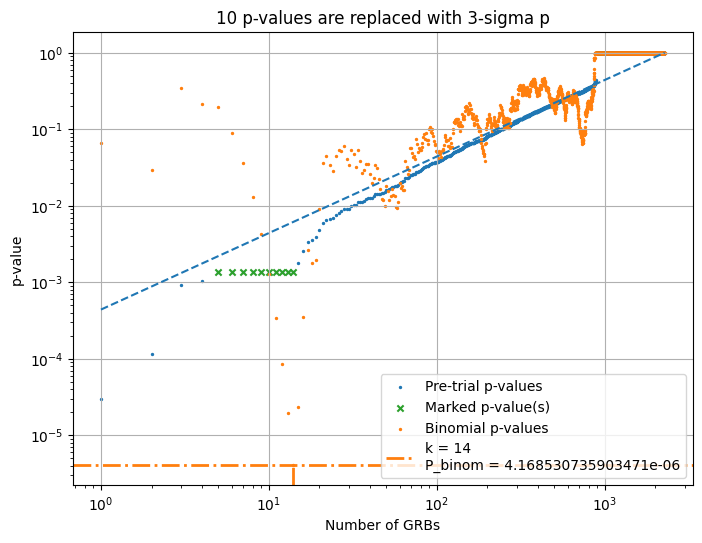

In [75]:
idx=3
num_to_replace=10
sigma=3
replaced_p=stats.norm.sf(sigma)
replaced_p_values, replaced_indices = get_replaced_p_values(
                                            p_values=multiple_run_post_p_permuted[idx], 
                                            num_to_replace=num_to_replace,
                                            grb_name_indices_to_replace=[], 
                                            replaced_p=replaced_p, 
                                            seed=0,
                                            return_replaced_indices=True
                                        )

ax,_ = plot_binom_example_from_p_values(
    replaced_p_values, 
    mark_indices=replaced_indices
)
ax.set_title(f"{num_to_replace} p-values are replaced with {sigma}-sigma p")

## 2.2 Replace p-values with actual injection p-values

In [96]:
def get_injection_min_tw_p_for_grb(grb_name, ninj):
    """
    Based on background TS distribution, return p_values using signal_ts for this grb
    
    Parameters
    ----------
        grb_name: string
            GRBxxxxxxC
            
        ninj: float or array_like
            has to have exact number(s) of precision as ninj in file names 
            e.g 2.4
            when ninj is an array (size 6), it means the 0-index ninj for tw=10s
            1-index ninj for tw=25s and so on
        
    Returns
    -------
        p_values: float or array_like
            type depends on `signal_ts`'s type
            
    """
    sig_files = sorted(glob(ANA_DIR + f"/prior_injection/tw*/{grb_name}/*_ninj{ninj}.npy"), 
                 key=lambda x: int(x[x.find("/tw")+3:x.find(f"/{grb_name}")]))
    sigs = np.array([np.load(sig_file) for sig_file in sig_files])
    sigs = sigs['ts']
    
    bg_files = sorted(glob(ANA_DIR + f"/allsky_scan/with_prior_background/tw*/{grb_name}_*.npz"), 
                 key=lambda x: int(x[x.find("/tw")+3:x.find(f"/{grb_name}")]))
    bgs = np.array([sparse.load_npz(bg_file).toarray()[0] for bg_file in bg_files])
    bgs_sorted = np.apply_along_axis(sorted, 1, bgs)
    
    pvals = []
    for sig, bg_sorted in zip(sigs, bgs_sorted):
        pvals.append(np.apply_along_axis(lambda x: np.maximum((bg_sorted.size - np.searchsorted(bg_sorted, x, side='left'))/bg_sorted.size, 1./bg_sorted.size), 0, sig))
    pvals = np.array(pvals)
    
    min_tw_p = cy.utils.Arrays({
        'tw_idx':np.argmin(pvals, axis=0), 
        'min_p':pvals.min(axis=0)
    }, names=['tw_idx', 'min_p'])
    
    return min_tw_p
    

In [77]:
## test
grb_name = "GRB180423A"
ninj = 2.6
get_injection_min_tw_p_for_grb(grb_name, ninj)

Arrays(500 items | columns: min_p, tw_idx)

In [78]:
grb_names = ['GRB180423A', 'GRB150716A', 'GRB160822A',
#              'GRB190623A', 
             'GRB160709B']
ninj=2.6
first_N_grb = 3

trial_idx = 0
idx=3


Text(0.5, 1.0, '3 p-value(s) are replaced with Ninj=2.6 p-values')

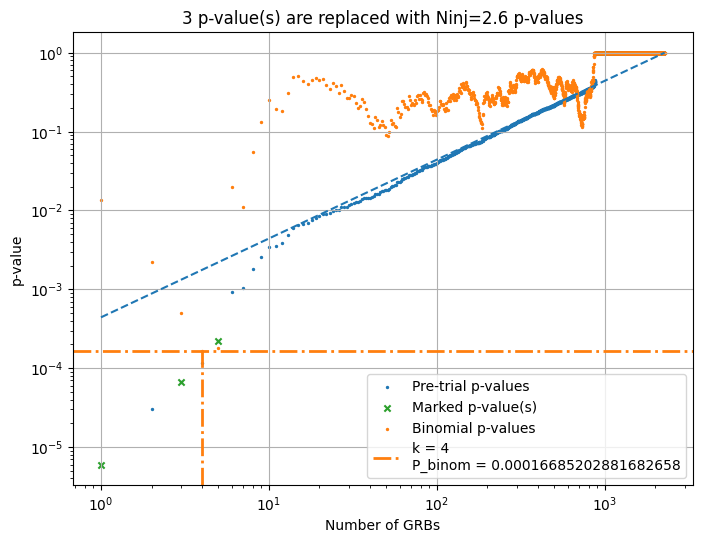

In [80]:
num_to_replace=-1
first_N_grb_names = grb_names[:first_N_grb]
replaced_p = np.ravel(
    np.array(
        [get_post_p_for_grb(x, get_injection_min_tw_p_for_grb(x, ninj)[trial_idx]['min_p']) for x in first_N_grb_names]
    )
)
grb_name_indices_to_replace = np.ravel(np.array([df.loc[df['grb_name'] == x].index for x in first_N_grb_names]))


replaced_p_values, replaced_indices = get_replaced_p_values(
                                            p_values=multiple_run_post_p_permuted[idx], 
                                            num_to_replace=num_to_replace,
                                            grb_name_indices_to_replace=grb_name_indices_to_replace, 
                                            replaced_p=replaced_p, 
                                            seed=0,
                                            return_replaced_indices=True
                                        )

ax,_ = plot_binom_example_from_p_values(
    replaced_p_values, 
    mark_indices=replaced_indices
)
ax.set_title(f"{first_N_grb} p-value(s) are replaced with Ninj={ninj} p-values")



## 2.3 Binomial Discovery Potential

In [205]:
np.unique(best_binomial_p_100000000).shape

(16423641,)

6.510555612841104e-09 2.866515718791933e-07


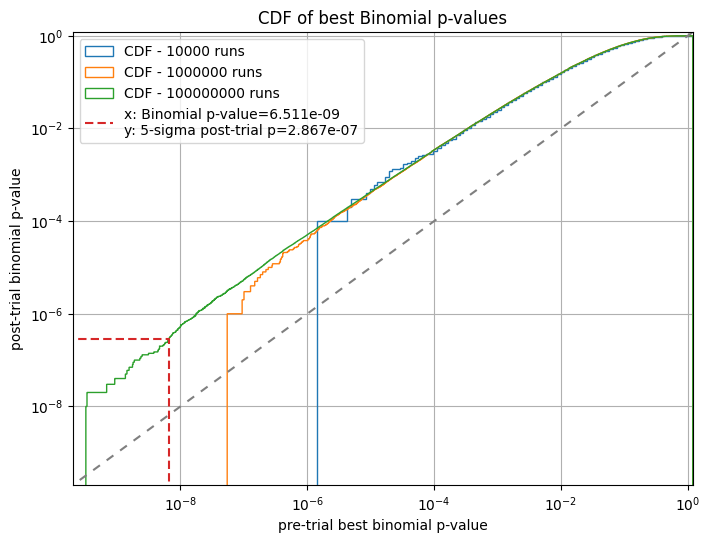

In [297]:
sigma = 5
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
n,bins,patches=ax.hist(best_binomial_p_10000, 
                       bins=np.r_[
                           np.logspace(np.log10(best_binomial_p_10000.min()),np.log10(1.0), 100), 
                           1.2
                       ],
        density=True, 
        cumulative=True, 
        label=f'CDF - {best_binomial_p_10000.size} runs',
        histtype='step')

n,bins,patches=ax.hist(best_binomial_p_1000000, 
                       bins=np.r_[
                           np.logspace(np.log10(best_binomial_p_1000000.min()),np.log10(1.0), 1000), 
                           1.2
                       ],
        density=True, 
        cumulative=True, 
        label=f'CDF - {best_binomial_p_1000000.size} runs',
        histtype='step')

n,bins,patches=ax.hist(best_binomial_p_100000000, 
                       bins=np.r_[
                           np.logspace(np.log10(best_binomial_p_100000000.min()),np.log10(1.0), 100000), 
                           1.2
                       ],
        density=True, 
        cumulative=True, 
        label=f'CDF - {best_binomial_p_100000000.size} runs',
        histtype='step')

x = np.linspace(*ax.get_xlim())
ax.plot(x, x, "--", color=sns.color_palette()[7], dashes=[4,4])
# 3-sigma discovery potential post Binomial
dp_y = stats.norm.sf(sigma)
dp_x = bins[np.searchsorted(n, dp_y, side='right')]
# ax.axvline(dp_x, color=sns.color_palette()[2], label=f"Binomial p-value={dp_x:.3e}")
# ax.axhline(dp_y, color=sns.color_palette()[3], label=f"{sigma}-sigma post-trial p-value={dp_y:.3e}")
ax.plot([dp_x, dp_x, 0],[0, dp_y, dp_y], 
        color=sns.color_palette()[3], dashes=[4, 2], 
        label=f"x: Binomial p-value={dp_x:.3e} \ny: {sigma}-sigma post-trial p={dp_y:.3e}")


ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.2e-9, 1.2)
ax.set_ylim(0.2e-9, 1.2)
ax.set_xlabel("pre-trial best binomial p-value")
ax.set_ylabel("post-trial binomial p-value")
ax.set_title(f"CDF of best Binomial p-values")
ax.grid(True)
ax.legend()
print(dp_x, dp_y)

In [48]:
# See slack chat with Kunal

In [88]:
stats.norm.sf(5)

2.866515718791933e-07

In [213]:
def get_binomial_discovery(
    multiple_run_p, 
    num_grb, 
    replaced_p=stats.norm.sf(5), 
    dp_x=6.510555612841104e-09, 
    seed=0,
    poisson=True
):
    """
    For one run among num_run(=multiple_run_p.shape[0]) runs, we replace num_grb grbs' 
    time-window corrected p-values with replaced_p's, and 
    get the resulting best binomial p-value 
    (first `get_replaced_p_values`, then `binomial_test`)
    
    For num_run runs, we get the ratio of 
        number of runs of which best p <= dp_x
        /
        num_runs
        
    Parameters
    ----------
        multiple_run_p: ndarray
            num_rum * 2268 p-values sent into binomial_test
            
        num_grb: float or array_like
            number of p-values will be replaced
            
        dp_x: float
            threshold binomial p-value
            
        replaced_p: float
            hypothetical replaced p-values
            e.g. stats.norm.sf(3)
            
        seed: int
            seed used for selecting num_grb p-values
            
        poisson: bool
            if True, num_grb is the poisson mean
        
    Returns
    -------
        passing_function: float or array_like
            each element is the PF for each num_grb
    """
    num_run = multiple_run_p.shape[0]
    num_grb = np.ravel(num_grb)
    
    passing_function = []
    for num in num_grb:
        random = np.random.RandomState(seed)
        if poisson:
            nums_to_replace = random.poisson(lam=num, size=num_run)
        else:
            nums_to_replace = np.repeat(num, num_run)
        indices_candidates = random.rand(num_run, 2268).argpartition(nums_to_replace.max(),axis=1)[:,:nums_to_replace.max()]
        best_binomial_ps = []
        for i in range(num_run):
            num_to_replace = nums_to_replace[i]
            indices = indices_candidates[i][:num_to_replace]
            # print(f"indices {indices}")
            new_p_values = get_replaced_p_values(
                multiple_run_p[i],
                num_to_replace=-1,
                grb_name_indices_to_replace=indices,
                replaced_p=replaced_p
            )
            _, best_binomial_p, _, _, _ = binomial_test(new_p_values)
            best_binomial_ps.append(best_binomial_p)
        best_binomial_ps = np.array(best_binomial_ps)
        # print(f"best_binomial_ps {best_binomial_ps}")
        passing_function.append(1.0*np.sum(best_binomial_ps<dp_x)/best_binomial_ps.size)
    return passing_function

In [214]:
### about 1 hr

# sigmas = [5,4,3]
# poissons = [True, False]
# for sigma in sigmas:
#     for poisson in poissons:
#         res = get_binomial_discovery(
#             multiple_run_post_p_permuted, 
#             np.r_[0:31],
#             replaced_p=stats.norm.sf(sigma),
#             dp_x=6.510555612841104e-09,
#             seed=0,
#             poisson=poisson
#             )
# #         print(ANA_DIR+f"/binomial_test/inj_binom/binom_disc/binom_disc_PF_sigma{sigma}_poisson{1 if poisson else 0}_num1-20.npy")
#         np.save(
#             ANA_DIR+f"/binomial_test/inj_binom/binom_disc/binom_disc_PF_sigma{sigma}_poisson{1 if poisson else 0}_num0-30.npy", 
#             res
#         )

In [215]:
get_binomial_discovery(
    multiple_run_post_p_permuted[:10], 
    np.r_[30],
    replaced_p=stats.norm.sf(3),
    seed=0,
    poisson=True
    )

[1.0]

In [4]:
binom_disc_PF = pd.DataFrame()
sigmas = [5,4,3]
# poissons = [1, 0]
poissons = [1]
for sigma in sigmas:
    for poisson in poissons:
        binom_disc_PF[f'{sigma}-sigma_{True if poisson else False}'] = np.load(
            ANA_DIR+f"/binomial_test/inj_binom/binom_disc/binom_disc_PF_sigma{sigma}_poisson{poisson}_num0-30.npy"
        )

In [5]:
binom_disc_PF.head()

,5-sigma_True,4-sigma_True,3-sigma_True
0,0.0000,0.0000,0.0000
1,0.0798,0.0012,0.0000
2,0.3112,0.0236,0.0000
3,0.5703,0.0973,0.0001
4,0.7553,0.2369,0.0005


In [6]:
binom_disc_PF["number_of_sources"] = binom_disc_PF.index
binom_disc_PF_long = pd.wide_to_long(binom_disc_PF, 
                                   stubnames=['5-sigma', '4-sigma', '3-sigma'], 
                                   i='number_of_sources',
                                   j='Use Poisson',
                                   sep='_', 
                                    suffix=r'\w+')
binom_disc_PF_long.reset_index(level=None, inplace=True)
binom_disc_PF_long = pd.melt(
    binom_disc_PF_long, 
    id_vars=['number_of_sources','Use Poisson'], 
    var_name='Simulated Flares'
)
binom_disc_PF_long.head()

,number_of_sources,Use Poisson,Simulated Flares,value
0,0,True,5-sigma,0.0000
1,1,True,5-sigma,0.0798
2,2,True,5-sigma,0.3112
3,3,True,5-sigma,0.5703
4,4,True,5-sigma,0.7553


In [39]:
tmp_style = {
    'text.usetex' : False,
    'mathtext.rm' : 'Times New Roman',
    'mathtext.it' : 'Times New Roman:italic',
    'mathtext.bf' : 'Times New Roman:bold',
    'mathtext.fontset': 'stix',
    'xtick.labelsize' : 16,
    'ytick.labelsize' : 16,
    'xtick.major.size' : 5,
    'ytick.major.size' : 5,
    'xtick.minor.size' : 3,
    'ytick.minor.size' : 3,
    'axes.labelsize' : 18,
    'xtick.direction' : 'in',
    'ytick.direction' : 'in',
    'ytick.right' : True,
    'xtick.top' : True,
    'axes.grid' : True,
    'axes.grid.which' : 'major',
    'axes.linewidth': 1.5,
    'grid.color' : 'lightgrey',
    'grid.alpha' : 0.4,
    'grid.linewidth' : 0.75,
    'lines.linewidth' : 1.5,
    'font.size' : 16,
    'image.cmap': 'PuBu',
}

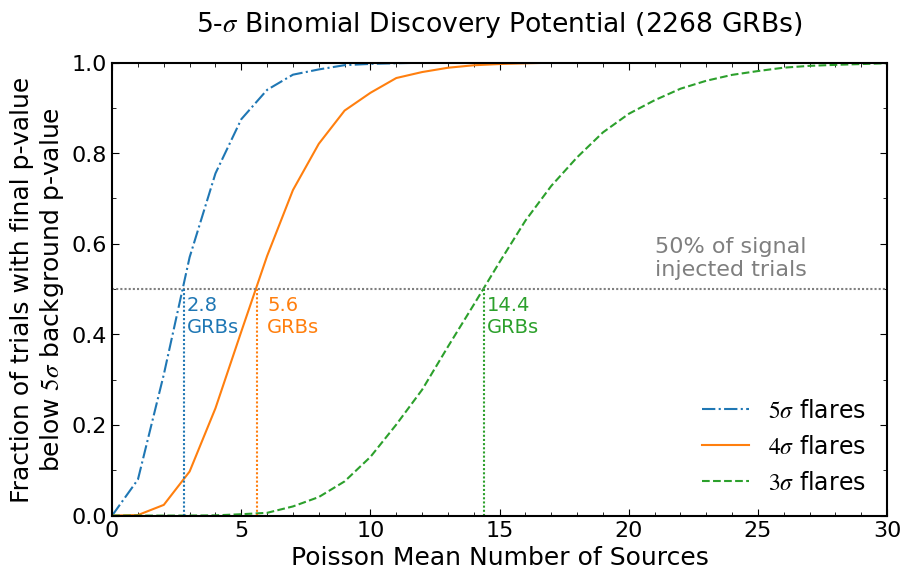

In [40]:
with mpl.rc_context(tmp_style):
    fig, ax = plt.subplots(figsize=(10,6), dpi=100)

    sig5 = ax.plot(np.r_[0:31], binom_disc_PF['5-sigma_True'], linestyle='dashdot', color=sns.color_palette()[0], label=r"$5\sigma$ flares")
    ax.plot(np.r_[0:31], binom_disc_PF['4-sigma_True'], linestyle='solid', color=sns.color_palette()[1], label=r"$4\sigma$ flares")
    ax.plot(np.r_[0:31], binom_disc_PF['3-sigma_True'], linestyle='dashed', color=sns.color_palette()[2], label=r"$3\sigma$ flares")

    # ax.plot(np.r_[0:31], binom_disc_PF['5-sigma_False'], marker='+', linestyle='--',color=sns.color_palette()[0])
    # ax.plot(np.r_[0:31], binom_disc_PF['4-sigma_False'], marker='+', linestyle='--',color=sns.color_palette()[1])
    # ax.plot(np.r_[0:31], binom_disc_PF['3-sigma_False'], marker='+', linestyle='--',color=sns.color_palette()[2])

    ax.axhline(y=0.5, linestyle=(0, (1, 1)), color=sns.color_palette()[7])
    ax.plot([2.8, 2.8],[0, 0.5], linestyle=(0, (1, 1)), color=sns.color_palette()[0])
    ax.plot([5.6, 5.6],[0, 0.5], linestyle=(0, (1, 1)), color=sns.color_palette()[1])
    ax.plot([14.4, 14.4],[0, 0.5], linestyle=(0, (1, 1)), color=sns.color_palette()[2])

    ax.text(21, 0.53, "50% of signal \ninjected trials", color=sns.color_palette()[7])
    plt.gcf().text(0.20, 0.43, "2.8\nGRBs", fontsize=14, color=sns.color_palette()[0], transform=plt.gcf().transFigure) 
    plt.gcf().text(0.28, 0.43, "5.6\nGRBs", fontsize=14, color=sns.color_palette()[1], transform=plt.gcf().transFigure) 
    plt.gcf().text(0.50, 0.43, "14.4\nGRBs", fontsize=14, color=sns.color_palette()[2], transform=plt.gcf().transFigure) 

    locminx = mpl.ticker.MultipleLocator(1)
    ax.xaxis.set_minor_locator(locminx)
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    locminy = mpl.ticker.MultipleLocator(0.1)
    ax.yaxis.set_minor_locator(locminy)
    ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    
    ax.set_xlim(0, 30)
    ax.set_ylim(-0.00, 1.00)
    ax.set_xlabel("Poisson Mean Number of Sources")
    ax.set_ylabel("Fraction of trials with final p-value" + "\n" + r"below $5\sigma$ background p-value")
    ax.set_title(r"5-$\sigma$ Binomial Discovery Potential (2268 GRBs)", y=1.05)
    ax.grid(False)
    ax.legend(fontsize=17, frameon=False)

In [17]:
sig5[0].get_xydata()

array([[ 0.    ,  0.    ],
       [ 1.    ,  0.0798],
       [ 2.    ,  0.3112],
       [ 3.    ,  0.5703],
       [ 4.    ,  0.7553],
       [ 5.    ,  0.875 ],
       [ 6.    ,  0.9398],
       [ 7.    ,  0.9733],
       [ 8.    ,  0.9849],
       [ 9.    ,  0.9943],
       [10.    ,  0.9971],
       [11.    ,  0.9985],
       [12.    ,  0.9997],
       [13.    ,  0.9998],
       [14.    ,  0.9999],
       [15.    ,  1.    ],
       [16.    ,  1.    ],
       [17.    ,  1.    ],
       [18.    ,  1.    ],
       [19.    ,  1.    ],
       [20.    ,  1.    ],
       [21.    ,  1.    ],
       [22.    ,  1.    ],
       [23.    ,  1.    ],
       [24.    ,  1.    ],
       [25.    ,  1.    ],
       [26.    ,  1.    ],
       [27.    ,  1.    ],
       [28.    ,  1.    ],
       [29.    ,  1.    ],
       [30.    ,  1.    ]])

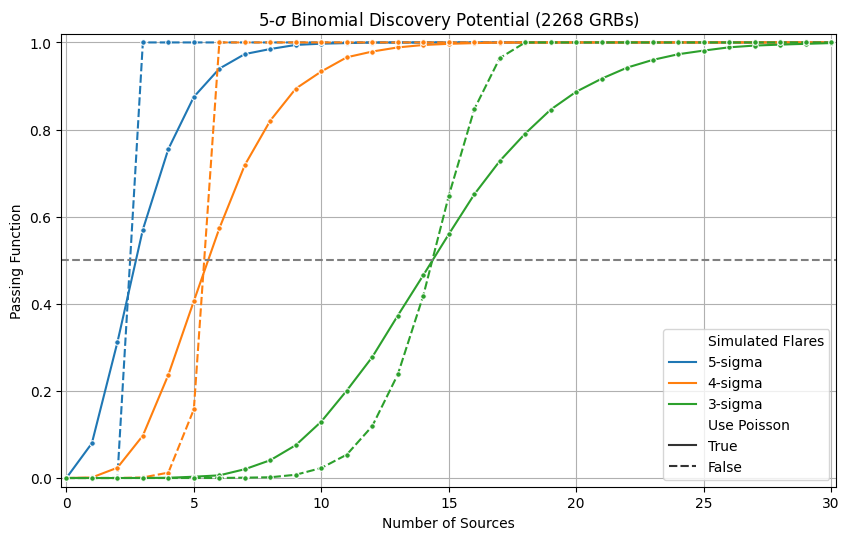

In [293]:
fig, ax = plt.subplots(figsize=(10,6), dpi=100)

sns.lineplot(data=binom_disc_PF_long, 
             x='number_of_sources', y='value', 
             hue='Simulated Flares', style='Use Poisson', marker='.', markersize=8,
             ax=ax)

x = np.linspace(*ax.get_xlim())
ax.plot(x, np.full_like(x, 0.5), "--", color=sns.color_palette()[7])

ax.set_xlim(-0.2, 30.2)
ax.set_ylim(-0.02, 1.02)
ax.set_xlabel("Number of Sources")
ax.set_ylabel("Passing Function")
ax.set_title(r"5-$\sigma$ Binomial Discovery Potential (2268 GRBs)")
ax.grid(True)
ax.legend()